## Random tests for coef

In [56]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt

from algorithms import BMP
from data_generation import GaussianDataGenerator

In [57]:
p = 600
n = 300
m = 20
noise_level = 0.2

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, random_seed=1)
_ = Data_Geneartor.shuffle()

In [58]:
(
    test_true_signal,
    test_dictionary,
    true_indices,
    true_coefficients,
    test_perturbed_signal,
) = Data_Geneartor.get_current_shuffle()
print(test_perturbed_signal[:5])
print(true_coefficients[:5])

[[-0.19962958]
 [-0.37186517]
 [-0.20171144]
 [ 0.3839525 ]
 [ 0.28456818]]
[[ 0.82356385]
 [ 0.39110083]
 [ 0.27774159]
 [ 0.39934474]
 [-1.42959629]]


In [59]:
train_seed = 33
(
    train_true_signal,
    train_dictionary,
    true_indices,
    true_coefficients,
    train_perturbed_signal,
) = Data_Geneartor.keep_coef_reshuffle(seed = train_seed)

In [60]:
model_params = {
    'N_bag': 20,
    'K': 1,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

bmp_model = BMP(**model_params)

In [61]:
bmp_model.fit(train_dictionary, train_perturbed_signal)
y_pred = bmp_model.predict(test_dictionary)
bmp_model.score(test_dictionary, test_perturbed_signal)

0.08315845265323628

In [62]:
bmp_model.pred_corr(test_dictionary).shape

(190,)

---------------------------

## Bias and Variance of single bmp

In [63]:
test_num = 1000
N_bag = 1

model_params_single = {
    'N_bag': N_bag,
    'K': 20,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed 
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
    fit_coef_lst.append(coef_tmp)
    
fit_coef_single_mat = np.concatenate(fit_coef_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients
true_coef_vec.shape

(600, 1)

In [64]:
fit_coef_single_mat.shape

(600, 1000)

In [65]:
fit_coef_single_mean = np.mean(fit_coef_single_mat, axis=1)
fit_coef_single_mean.shape

(600,)

In [66]:
fit_coef_single_mean

array([-3.87769679e-04,  2.02253319e-03, -2.83977749e-03,  1.88979208e-03,
       -3.93874780e-03, -3.43405936e-04,  6.09486566e-04,  1.12006949e-03,
        1.16867593e-03, -4.08023939e-03,  2.31207778e-03, -1.55363539e-03,
        2.74468447e-03,  1.65052507e-04,  3.94232666e-03, -1.15323427e-03,
       -1.78309657e-03,  1.11728879e-03, -3.13805315e-04,  1.57668054e-01,
        1.53003063e-03,  1.23230123e-03,  7.58646311e-05,  6.33693230e-04,
       -1.68553853e-04, -6.30794901e-05,  9.09893760e-05, -3.54524151e-04,
        2.22887844e-03,  2.74614110e-03, -2.90016695e-03,  8.36602413e-04,
        3.97145025e-03,  3.91796256e-04, -7.55755895e-04,  2.87307584e-03,
        1.55849770e-03, -4.91380895e-03,  5.66339183e-04, -3.17932992e-03,
       -6.66400110e-04,  1.11229232e-03,  1.42047546e-03,  3.26184857e-03,
       -1.55517364e-03,  1.44753057e-04,  4.23902505e-04,  7.74624265e-01,
        1.94139356e-03,  2.82385429e-03,  2.92090436e-03, -5.00383250e-03,
       -1.61325605e-03,  

In [67]:
fit_coef_single_bias = true_coef_vec.ravel() - fit_coef_single_mean.ravel()
fit_coef_single_bias.shape

(600,)

In [68]:
fit_coef_single_mean.shape

(600,)

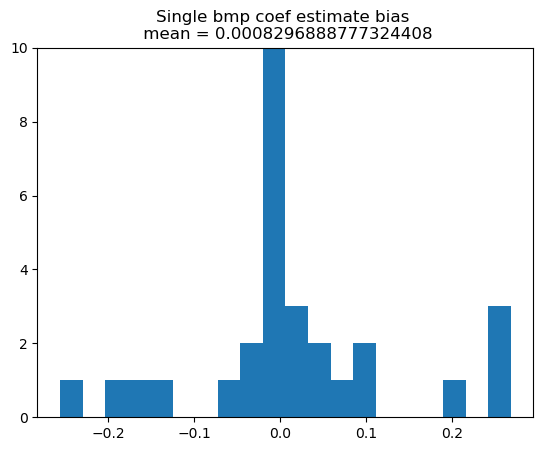

In [69]:
plt.hist(fit_coef_single_bias, bins=20)
fit_coef_single_bias_mean = np.mean(fit_coef_single_bias)
plt.title(f"Single bmp coef estimate bias \n mean = {fit_coef_single_bias_mean}")
plt.ylim((0,10))
plt.show()

Variance of single mp

In [70]:
fit_coef_single_mat.shape

(600, 1000)

In [71]:
fit_coef_single_var = np.var(fit_coef_single_mat, axis=1)
fit_coef_single_var.shape

(600,)

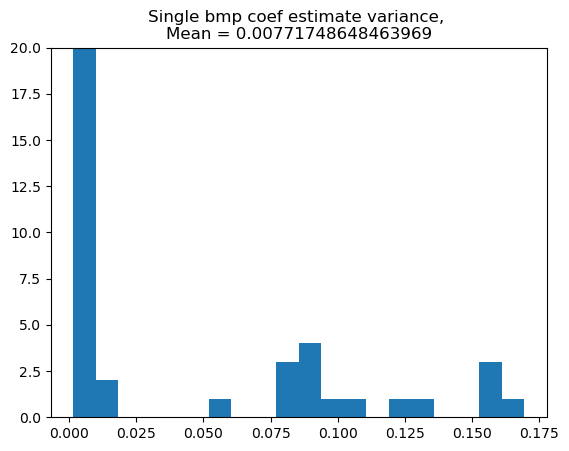

In [72]:
plt.hist(fit_coef_single_var, bins=20)
fit_coef_single_var_mean = np.mean(fit_coef_single_var)
plt.title("Single bmp coef estimate variance, \nMean = " + str(fit_coef_single_var_mean))
plt.ylim((0, 20))
plt.show()

----------------------

## MSE of ensembled model

In [168]:
test_num = 300
N_bag = 200

model_params_ensemble = {
    'N_bag': N_bag,
    'K': 20,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_ensemble_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_ensemble['random_seed'] = None
    bmp_model_ensemble = BMP(**model_params_ensemble)
    bmp_model_ensemble.fit(train_dictionary, train_perturbed_signal)
    fit_coef_tmp = bmp_model_ensemble.coefficients.reshape(-1, 1)
    fit_coef_ensemble_lst.append(fit_coef_tmp)
    
fit_coef_ensemble_mat = np.concatenate(fit_coef_ensemble_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients

In [169]:
fit_coef_ensemble_mat.shape

(600, 300)

In [170]:
ensemble_coef_bias_multitrial = np.mean(fit_coef_ensemble_mat, axis = 1) - true_coef_vec.ravel()

In [171]:
ensemble_coef_var_multitrial = np.var(fit_coef_ensemble_mat, axis = 1)

(0.0, 10.0)

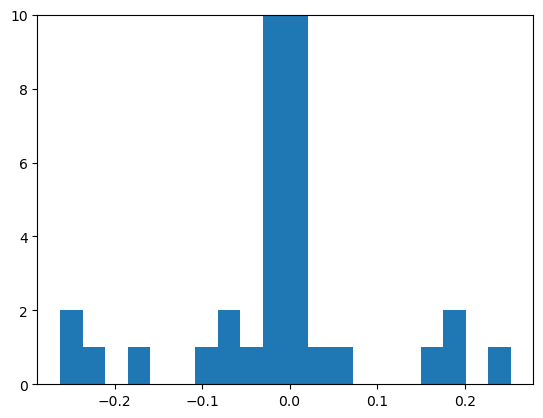

In [167]:
plt.hist(ensemble_coef_bias_multitrial, bins=20)
plt.ylim((0, 10))

(0.0, 20.0)

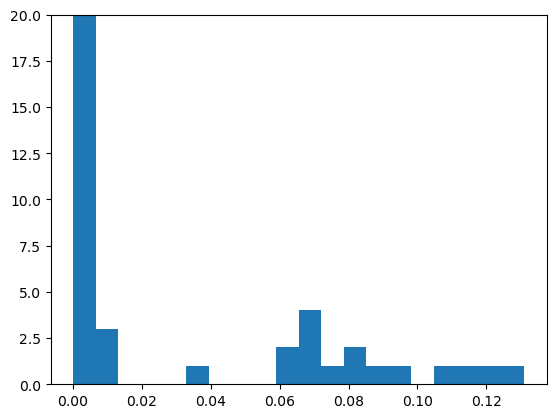

In [173]:
plt.hist(ensemble_coef_var_multitrial, bins=20)
plt.ylim((0, 20))

In [174]:
ensemble_coef_diff_multitrial = fit_coef_ensemble_mat - true_coef_vec
ensemble_coef_sq_bias_multitrial = ensemble_coef_diff_multitrial ** 2
ensemble_coef_sq_bias_multitrial.shape

(600, 300)

In [175]:
ensemble_coef_sq_bias_multitrial_exp = np.mean(ensemble_coef_sq_bias_multitrial, axis = 1)
ensemble_coef_sq_bias_multitrial_exp.shape

(600,)

In [176]:
test_en_mse = ensemble_coef_var_multitrial + ensemble_coef_bias_multitrial ** 2

(array([ 4., 15., 35., 36., 42., 39., 44., 38., 50., 31., 38., 20., 26.,
        29., 13., 16., 13., 17., 15., 17.,  9.,  9.,  8.,  5.,  8.,  5.,
         2.,  3.,  5.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.]),
 array([0.02827077, 0.06487412, 0.10147746, 0.13808081, 0.17468416,
        0.21128751, 0.24789085, 0.2844942 , 0.32109755, 0.3577009 ,
        0.39430425, 0.43090759, 0.46751094, 0.50411429, 0.54071764,
        0.57732098, 0.61392433, 0.65052768, 0.68713103, 0.72373438,
        0.76033772, 0.79694107, 0.83354442, 0.87014777, 0.90675112,
        0.94335446, 0.97995781, 1.01656116, 1.05316451, 1.08976785,
        1.1263712 , 1.16297455, 1.1995779 , 1.23618125, 1.27278459,
        1.30938794, 1.34599129, 1.38259464, 1.41919799, 1.45580133,
        1.49240468]),
 <BarContainer object of 40 artists>)

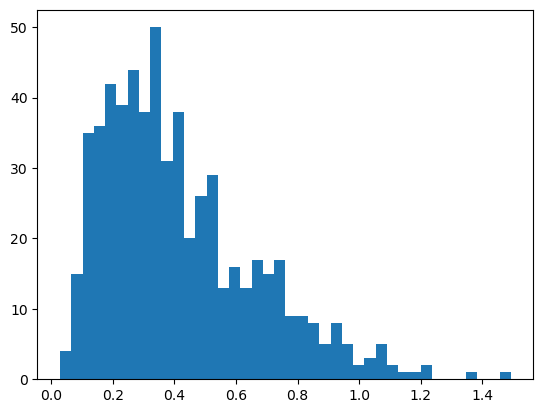

In [190]:
variance_ratio = []
true_indices_variance_ratio = []

for i in range(len(ensemble_coef_var_multitrial)):
    single_var = fit_coef_single_var[i]
    ensemble_var = ensemble_coef_var_multitrial[i]
    variance_ratio.append(ensemble_var / single_var)
    if i in true_indices:
        true_indices_variance_ratio.append(ensemble_var / single_var)

plt.hist(variance_ratio, bins=40)

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 2., 1., 1., 1., 1., 2., 0., 1., 0., 2., 0.,
        1., 3., 1., 0., 0., 1.]),
 array([0.32474362, 0.33941555, 0.35408747, 0.3687594 , 0.38343132,
        0.39810324, 0.41277517, 0.42744709, 0.44211901, 0.45679094,
        0.47146286, 0.48613479, 0.50080671, 0.51547863, 0.53015056,
        0.54482248, 0.5594944 , 0.57416633, 0.58883825, 0.60351018,
        0.6181821 , 0.63285402, 0.64752595, 0.66219787, 0.67686979,
        0.69154172, 0.70621364, 0.72088557, 0.73555749, 0.75022941,
        0.76490134, 0.77957326, 0.79424518, 0.80891711, 0.82358903,
        0.83826096, 0.85293288, 0.8676048 , 0.88227673, 0.89694865,
        0.91162057]),
 <BarContainer object of 40 artists>)

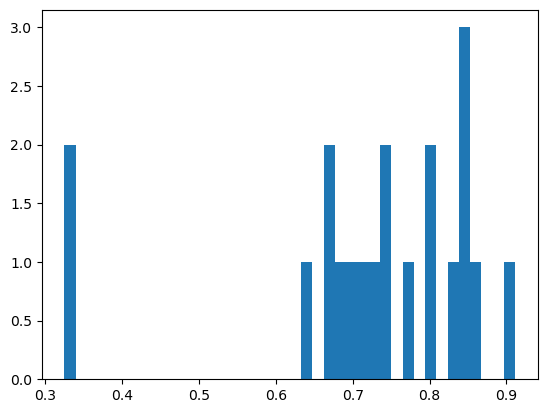

In [191]:
plt.hist(true_indices_variance_ratio, bins=40)

In [186]:
np.argmax(variance_ratio)

366

In [185]:
variance_ratio[366]

1.4924046807600346

In [187]:
true_coef_vec[366]

array([0.])

0.12314803748844633


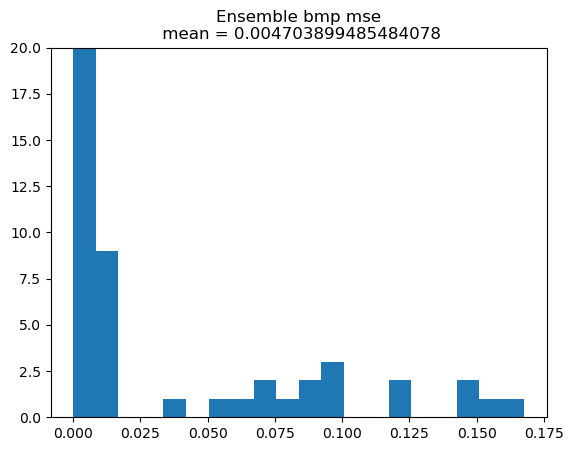

In [157]:
plt.hist(ensemble_coef_sq_bias_multitrial_exp, bins = 20)
ensemble_coef_sq_bias_multitrial_exp_mean = np.mean(ensemble_coef_sq_bias_multitrial_exp)
plt.title('Ensemble bmp mse\n mean = ' + str(ensemble_coef_sq_bias_multitrial_exp_mean))
plt.ylim((0, 20))
plt.show()

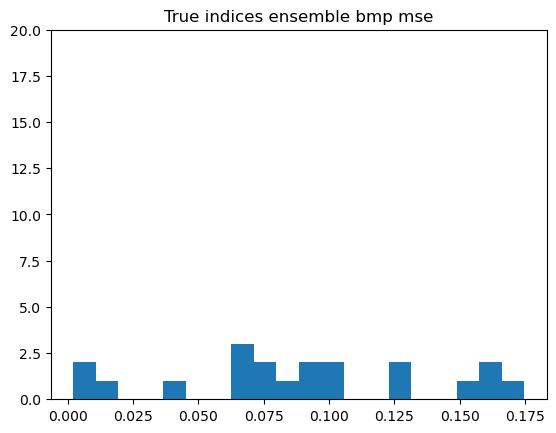

In [227]:
# True indices mse
true_indices_mse = ensemble_coef_sq_bias_multitrial_exp[true_indices]

plt.hist(true_indices_mse, bins = 20)
plt.title('True indices ensemble bmp mse')
plt.ylim((0, 20))
plt.show()

--------------

## Correlation

In [218]:
test_num = 500
N_bag = 200

model_params_single = {
    'N_bag': 1,
    'K': 20,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_bag_multitiral_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    fit_coef_bag = []
    for j in range(N_bag):
        model_params_single['random_seed'] = data_seed + j
        bmp_model_single = BMP(**model_params_single)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        fit_coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
        fit_coef_bag.append(fit_coef_tmp)
    fit_coef_bag_multitiral_lst.append(fit_coef_bag)

In [219]:
stack_lst = []
for i in range(len(fit_coef_bag_multitiral_lst)):
    tmp = np.concatenate(fit_coef_bag_multitiral_lst[i], axis=1)
    stack_lst.append(tmp)

d3 = np.stack(stack_lst)
d3.shape

(500, 600, 200)

In [220]:
slice_Nbag_testnum = d3[:, 1, :]
slice_Nbag_testnum.shape

(500, 200)

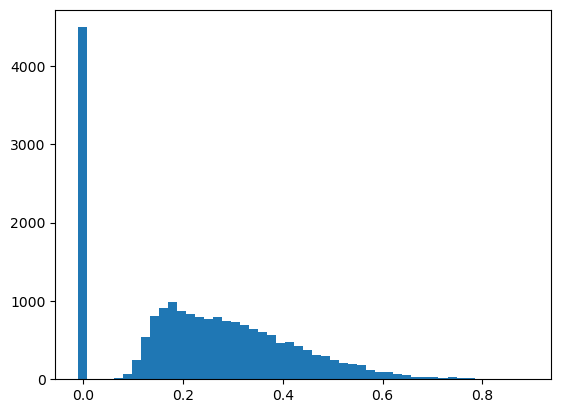

In [221]:
corr = np.corrcoef(slice_Nbag_testnum, rowvar=False)
corr.shape
upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
plt.hist(upper_corr, bins=50)
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/env_base/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/miniforge/base/envs/env_base/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


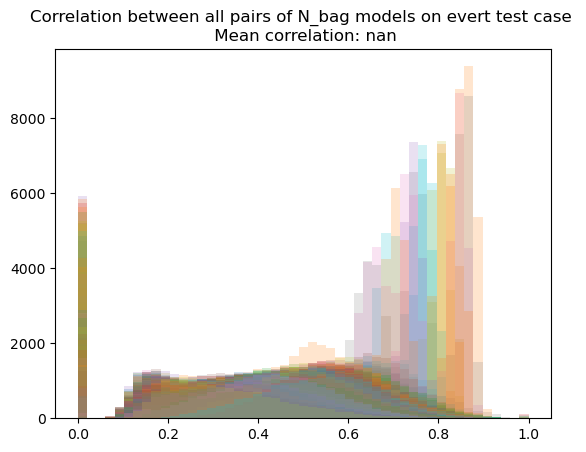

In [222]:
bins = np.linspace(0, 1, 50)
all_corr = []
mean_corr_lst = []

for i in range(d3.shape[1]):
    slice_tmp = d3[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    all_corr.extend(upper_corr)
    mean_corr = np.mean(upper_corr)
    mean_corr_lst.append(mean_corr)
    plt.hist(upper_corr, bins=bins, alpha=0.2, label='test case {}'.format(i))
mean_corr = np.mean(all_corr)
plt.title('Correlation between all pairs of N_bag models on evert test case \n Mean correlation: {:.3f}'.format(mean_corr))
plt.show()


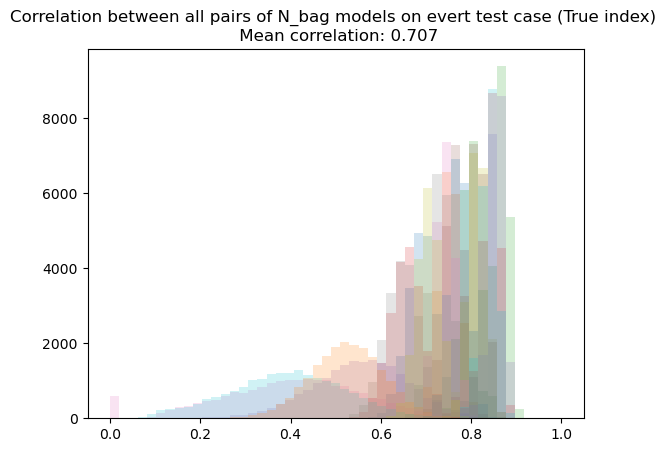

In [224]:
# true_indices
bins = np.linspace(0, 1, 50)
all_corr = []

for i in range(d3.shape[1]):
    if i in true_indices:
        slice_tmp = d3[:, i, :]
        corr = np.corrcoef(slice_tmp, rowvar=False)
        upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
        all_corr.extend(upper_corr)
        plt.hist(upper_corr, bins=bins, alpha=0.2, label='test case {}'.format(i))
mean_corr = np.mean(all_corr)
plt.title('Correlation between all pairs of N_bag models on evert test case (True index) \n Mean correlation: {:.3f}'.format(mean_corr))
plt.show()


In [199]:
true_indices

array([135, 521, 114, 259, 374, 321, 224,  19, 416, 357, 157, 431, 371,
        78,  47, 129, 326, 168, 291,  86])

## Combining bias variance and correlation

In [135]:
fit_coef_single_bias.shape

(600,)

In [136]:
fit_coef_single_var.shape

(600,)

In [137]:
ensemble_coef_sq_bias_multitrial_exp.shape

(600,)

In [138]:
coef_mean_corr = []

for i in range(d3.shape[1]):
    slice_tmp = d3[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    tmp_mean_corr = np.mean(upper_corr)
    coef_mean_corr.append(tmp_mean_corr)

coef_mean_corr = np.array(coef_mean_corr)
coef_mean_corr.shape

(600,)

In [139]:
coef_mean_corr[19]

0.4718471260409566

In [140]:
true_indices

array([385,  32, 345, 438, 569,  45, 490, 164,  59, 278,  82, 378,  68,
       106,  14, 506, 516,  92,   2, 151])

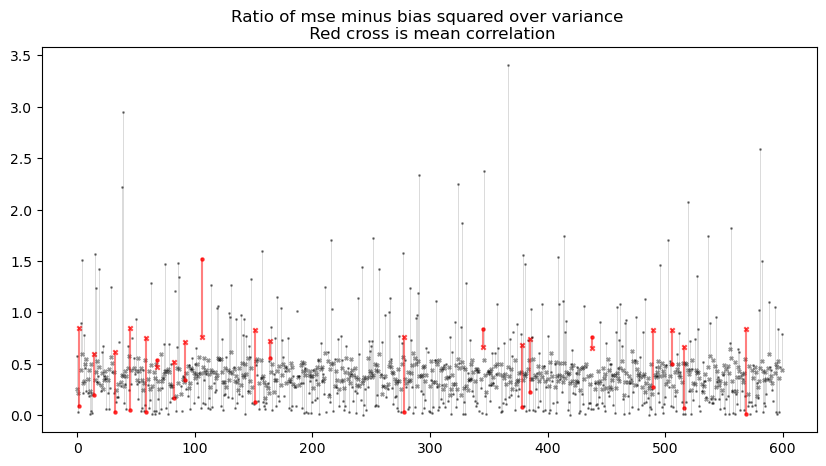

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(p):
    tmp_bias = fit_coef_single_bias[i]
    tmp_var = fit_coef_single_var[i]
    tmp_mse = ensemble_coef_sq_bias_multitrial_exp[i]
    tmp_corr = coef_mean_corr[i]
    mse_minus_biassq = tmp_mse - tmp_bias ** 2
    ratio_tmp = tmp_mse / tmp_var
    if i in true_indices:
        plt.scatter(i, ratio_tmp, alpha=0.7, s = 5, color = 'red')
        plt.scatter(i, tmp_corr, alpha=0.7, s = 10, color='red', marker= 'x')
        plt.plot([i, i], [ratio_tmp, tmp_corr], color='red', alpha=0.5, linewidth=1.5)
    else:
        plt.scatter(i, ratio_tmp, alpha=0.4, s = 1, color = 'black')
        plt.scatter(i, tmp_corr, alpha=0.4, s = 6, color='black', marker='x')
        plt.plot([i, i], [ratio_tmp, tmp_corr], color='black', alpha=0.2, linewidth=0.5)
plt.title('Ratio of mse minus bias squared over variance \n Red cross is mean correlation')
plt.show()